# WiDS 2018 Datathon

Predictive Analytics for Social Impact

Competition on [Kaggle](https://www.kaggle.com/c/wids2018datathon)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from helpers import format_submission

In [2]:
seed = 37

train = pd.read_csv('data/train.csv', low_memory=False)
test = pd.read_csv('data/test.csv', low_memory=False)

print 'Train Shape: {}'.format(train.shape)
print 'Test Shape: {}'.format(test.shape)

Train Shape: (18255, 1235)
Test Shape: (27285, 1234)


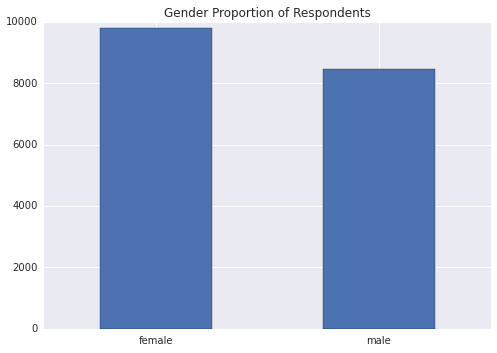

In [8]:
train.is_female.value_counts().plot(kind='bar', title='Gender Proportion of Respondents')
plt.xticks(np.arange(0,2), ['female', 'male'], rotation=0)
plt.show()

In [23]:
num_female = len(train[train.is_female==1])
num_male = len(train[train.is_female==0])
total = len(train)

print 'Percentage female: {:.2}%'.format(float(num_female)/total)
print 'Percentage male: {:.2}%'.format(float(num_male)/total)
print 'Total respondents: {}'.format(total)

Percentage female: 0.54%
Percentage male: 0.46%
Total respondents: 18255


In [17]:
# Downsample to address class imbalance
train_female = train[train.is_female == 1]
train_male = train[train.is_female == 0]
train_female_sample = train_female.sample(n=num_male, random_state=seed)
train_new = pd.concat([train_male, train_female_sample], axis=0, ignore_index=True).sample(frac=1)

In [24]:
num_female = len(train_new[train_new.is_female==1])
num_male = len(train_new[train_new.is_female==0])
total = len(train_new)

print 'Percentage female: {:.2}%'.format(float(num_female)/total)
print 'Percentage male: {:.2}%'.format(float(num_male)/total)
print 'Total respondents: {}'.format(total)

Percentage female: 0.5%
Percentage male: 0.5%
Total respondents: 16900


In [25]:
train = train_new.copy()

In [27]:
label = train['is_female']
del train['is_female']

del train['train_id']
del test['test_id']

# Remove rows/columns that are missing all data
train = train.dropna(axis=0, how='all')
train = train.dropna(axis=1, how='all')

# Convert to categorical
train_str = train.applymap(str)
train_dum = pd.get_dummies(train_str)

# Split into train and validation set
X_train, X_test, y_train, y_test = train_test_split(train_dum, label, test_size=0.2, random_state=42)

In [28]:
# Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
score = roc_auc_score(y_test, preds)

print 'Logistic Regression'
print 'ROC AUC Score: {}'.format(score)

Logistic Regression
ROC AUC Score: 0.885786873123


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# k-NN
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
score = roc_auc_score(y_test, preds)

print 'k-NN'
print 'ROC AUC Score: {}'.format(score)

In [30]:
# Fit XGBoost Classifier
start = time.time()
clf = XGBClassifier(max_depth=7, n_estimators=100, random_state=seed)
clf.fit(X_train, y_train, eval_metric='auc')

preds = clf.predict(X_test)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'XGBoost Classifier'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {:2} minutes'.format(run_time)

XGBoost Classifier
ROC AUC Score: 0.917382103482
Run time: 14.8318378647 minutes


In [13]:
# Tune max_depth (1-10) for XGBoost Classifier
start = time.time()

parameters = {'max_depth': range(1, 11, 2)}
xgb = XGBClassifier()
clf = GridSearchCV(xgb, parameters, scoring='roc_auc', refit=True)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'XGBoost Classifier Tuned with GridSearchCV'
print 'Best parameters: {}'.format(clf.best_params_)
print 'Best GridSearchCV ROC AUC score: {}'.format(clf.best_score_)
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {} minutes'.format(run_time)

XGBoost Classifier Tuned with GridSearchCV
Best parameters: {'max_depth': 7}
Best GridSearchCV ROC AUC score: 0.967213341827
ROC AUC Score: 0.911375481962
Run time: 139.383742003 minutes


In [31]:
# Format test set
test_str = test.applymap(str)
total = pd.concat([train_str, test_str], ignore_index=True)
total_dummies = pd.get_dummies(total)
train_dummies = total_dummies.head(len(train))
test_dummies = total_dummies.tail(len(test))

# # Export modified train and test sets to CSV to use with Keras
# train_dummies.to_csv('data/x_train.csv', index=False)
# pd.DataFrame(label).to_csv('data/y_train.csv', index=False)
# test_dummies.to_csv('data/x_test.csv', index=False)

In [ ]:
# Update submission number 
sub_number = 11

# Fit best model to full train set
start = time.time()
print 'Fitting model...\n'

clf = XGBClassifier(max_depth=7, n_estimators=100, random_state=seed)
clf.fit(train_dummies, label, eval_metric='auc')

# Make predictions
print 'Making predictions...\n'
preds = clf.predict_proba(test_dummies)

end = time.time()
run_time = float(end - start)/60
print 'Run time: {:0.2f} minutes\n'.format(run_time)

# Format submission 
print 'Formatting submission...\n'
df = format_submission(preds, len(test_dummies))
df.to_csv('submissions/submission{}.csv'.format(sub_number), index=False)

print 'Program complete!'

Fitting model...



In [8]:
# Cross-validation on full training set

# Update submission number 
start = time.time()
sub_number = 10

# GridSearchCV
print 'Tuning model...\n'
parameters = {'max_depth': range(1, 11, 2), 'n_estimators': range(50,300,50)}
xgb = XGBClassifier()
clf = GridSearchCV(xgb, parameters, scoring='roc_auc', refit=True)
clf.fit(train_dummies, label)

# Make predictions
print 'Making predictions...\n'
preds = clf.predict_proba(test_dummies)

# Format submission 
print 'Formatting submission...\n'
df = format_submission(preds, len(test_dummies))
df.to_csv('submissions/submission{}.csv'.format(sub_number), index=False)

end = time.time()
run_time = float(end - start)/60

print 'Program complete!\n'
print 'XGBoost Classifier Tuned with GridSearchCV'
print 'Best parameters: {}'.format(clf.best_params_)
print 'Best GridSearchCV ROC AUC score: {}'.format(clf.best_score_)
print 'Run time: {:0.2f} minutes'.format(run_time)

Tuning model...

Making predictions...


Formatting submission...

Program complete!

XGBoost Classifier Tuned with GridSearchCV
Best parameters: {'n_estimators': 250, 'max_depth': 9}
Best GridSearchCV ROC AUC score: 0.969377013799
Run time: 687.11 minutes
